# Reddit Depression Detection

Improvements
1. Autocorrect
2. Spell Check
3. Grammar Check

## Initialization

### Import Statements


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

### Import Dataset

In [2]:
df = pd.read_csv('dataset.csv')
df.head()

,Unnamed: 0,text,class
0,2,Ex Wife Threatening SuicideRecently I left my ...,suicide
1,3,Am I weird I don't get affected by compliments...,non-suicide
2,4,Finally 2020 is almost over... So I can never ...,non-suicide
3,8,i need helpjust help me im crying so hard,suicide
4,9,"I’m so lostHello, my name is Adam (16) and I’v...",suicide


### Dataset Transformation

In [3]:
df.drop(['Unnamed: 0'], axis=1, inplace=True)
df['class'] = df['class'].replace({'suicide':1,'non-suicide':0})
df.head()

C:\Users\Rishabh\AppData\Local\Temp\ipykernel_15812\3534510445.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class'] = df['class'].replace({'suicide':1,'non-suicide':0})


,text,class
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1


### Balanced Sampling

In [4]:
df = pd.concat([df[df['class']==1].head(16000), df[df['class']==0].tail(16000)],ignore_index=True)
# df[df['class']=='non-suicide'].tail(5000)

### Check Dimensions

In [5]:
df.shape

(32000, 2)

### Label Counts

In [6]:
df['class'].value_counts()

class
1    16000
0    16000
Name: count, dtype: int64

##### Balanced Dataset

### Remove Null/Duplicated Values

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.shape

(32000, 2)

## Preprocessing

### Demojification and Tag Removal

Removal of Hyperlinks, Emojis and r/ tokens

In [8]:
import re
df['text'] = [re.sub(r"[^a-z A-Z 0-9 \,\.!@#$%^&*_\(\)-=+\{\}\[\]:;'<>/?|`]", '', str(sentence)) for sentence in df['text']]    # Removes Emojis
df['text'] = [re.sub(r"https?://\S+", '', str(sentence)) for sentence in df['text']]                                            # Removes Hyperlinks
df['text'] = [re.sub(r"\br/\S+", '', str(sentence)) for sentence in df['text']]                                                 # Removes r/ Reddit Communities

### Lemmatization and Lowering

In [9]:
# python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm', disable=['ner','parser'])

# 5m 31s execution time
def preprocess(sentence):
    doc = nlp(sentence)
    lemmatized_tokens = [token.lemma_.lower() for token in doc if token.pos_ != 'PUNCT' and not token.is_stop]
    return ' '.join(token for token in lemmatized_tokens).strip()

# 3m 12s execution time
def batch_preprocess(sentences):
    lemmatized_texts = (' '.join(token.lemma_.lower() for token in doc if token.pos_ != 'PUNCT' and not token.is_stop).strip() for doc in nlp.pipe(sentences, batch_size=500, disable=['parser', 'ner'], n_process=2))
    return lemmatized_texts

df['text_lemma'] = list(batch_preprocess(df['text']))

## Model Building

### TF-IDF Vectorizing

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords

vectorizer = TfidfVectorizer(max_features=12000, stop_words=stopwords.words('english'), ngram_range=(1,2))
X_train, X_test, Y_train, Y_test = train_test_split(df['text_lemma'], df['class'], test_size=0.2, random_state=42)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

### Model Training

#### XGBoost

In [11]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
model = XGBClassifier()
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       0.89      0.92      0.91      3126
           1       0.93      0.89      0.91      3274

    accuracy                           0.91      6400
   macro avg       0.91      0.91      0.91      6400
weighted avg       0.91      0.91      0.91      6400



#### Random Forest Classifier

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
model = RandomForestClassifier()
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
accuracy_score(Y_test, Y_pred)

0.8925

#### Logistic Regression

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
model = LogisticRegression(solver='liblinear')
model.fit(X_train_vectorized, Y_train)
Y_pred = model.predict(X_test_vectorized)
accuracy_score(Y_test, Y_pred)

0.92296875

In [14]:
X_train_vectorized.shape

(25600, 12000)

### Deep Learning - ANN

Early stopping mechanism for optimality of epochs

In [15]:
from keras.callbacks import EarlyStopping
callback = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1, mode='auto', min_delta=0.00001, baseline=None)

Mini-Batch Gradient Descent with Optimised Loss and Maximal Accuracy

In [16]:
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Dropout
from keras.regularizers import l2
model = Sequential()
model.add(Dense(128, input_dim=X_train_vectorized.shape[1], activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
hist = model.fit(X_train_vectorized.toarray(), Y_train, epochs=20, validation_split=0.2,callbacks=callback, batch_size=64)

C:\Users\Rishabh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - accuracy: 0.5895 - loss: 0.6630 - val_accuracy: 0.8916 - val_loss: 0.3088
Epoch 2/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - accuracy: 0.8875 - loss: 0.2900 - val_accuracy: 0.9129 - val_loss: 0.2215
Epoch 3/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.9206 - loss: 0.2081 - val_accuracy: 0.9184 - val_loss: 0.2087
Epoch 4/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.9362 - loss: 0.1740 - val_accuracy: 0.9197 - val_loss: 0.2048
Epoch 5/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9416 - loss: 0.1583 - val_accuracy: 0.9166 - val_loss: 0.2058
Epoch 6/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9483 - loss: 0.1389 - val_accuracy: 0.9195 - val_loss: 0.2089
Epoch 7/20
320/320 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - accuracy: 0.9558 - loss: 0.1301 - val_accuracy: 0.9195 - val_loss: 0.2129
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


### Model Accuracy

In [17]:
Y_prob = model.predict(X_test_vectorized.toarray())
Y_pred = np.where(Y_prob>0.5, 1, 0)
model.evaluate(X_test_vectorized.toarray(), Y_test)

200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9280 - loss: 0.1836


[0.19786998629570007, 0.92578125]

### Accuracy Plots

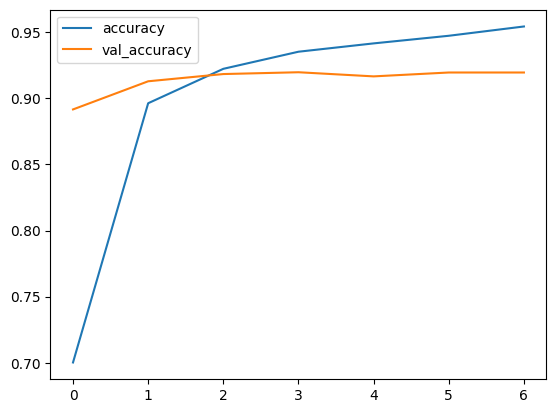

In [18]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'],loc='best')
plt.show()

### Loss Plots

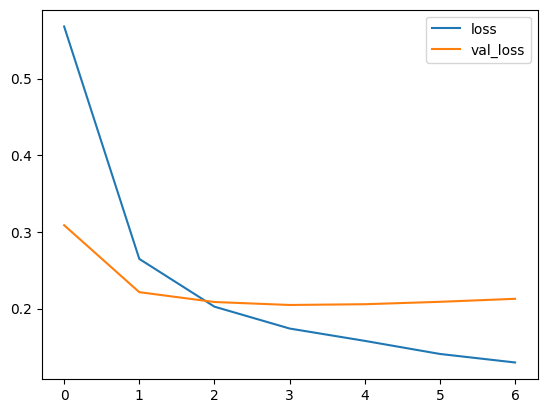

In [19]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.legend(['loss', 'val_loss'],loc='best')
plt.show()

### Confusion Matrix

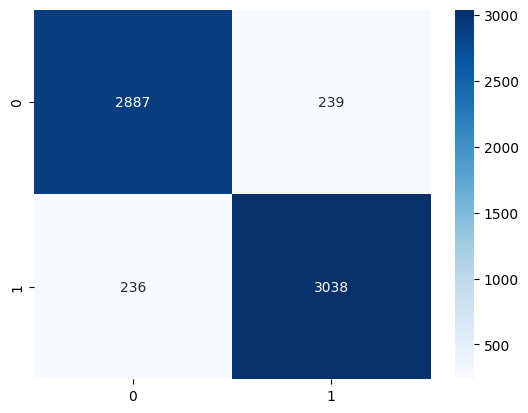

In [20]:
from tensorflow import math
cm = math.confusion_matrix(Y_test, Y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

### User Input

In [21]:
input1 = input("Enter expression to check depression: ")
input1 = preprocess(input1)
input_vectorized = vectorizer.transform([input1])
pred = model.predict(input_vectorized.toarray())
if np.where(pred>0.5,1,0)==1:
    print("Depressed")
else:
    print("Not Depressed")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
Not Depressed


### Summary of ANN Model

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │     1,536,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,633,349 (17.67 MB)

 Trainable params: 1,544,449 (5.89 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,088,900 (11.78 MB)

### Model Saving


In [23]:
keras.models.save_model(model, 'model.h5')
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)
with open('nlp.pkl', 'wb') as file:
    pickle.dump(nlp, file)